In [1]:
import gustaf as gus
import numpy as np
import splinepy as sp
import vedo

vedo.settings.default_backend = 'k3d'


import igl
import matplotlib.pyplot as plt
import torch

import deep_sdf.utils
from deep_sdf import workspace as ws
from sdf_sampler.plotting import scatter_contour_at_z_level

params = {'text.usetex': False, 'mathtext.fontset': 'cm', 'axes.labelsize': 12}
plt.rcParams.update(params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
experiment_directory = "../../experiments/double_lattice_3D_small_network"
checkpoint = "1000"

graded = True

latent = ws.load_latent_vectors(experiment_directory, checkpoint).to("cpu").numpy()
decoder = ws.load_trained_model(experiment_directory, checkpoint).to(device)
decoder.eval()
latent_base = np.array([0, -0.4])

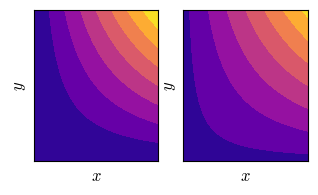

In [3]:
control_points_ungraded = np.array([latent_base]*4)
control_points_graded = control_points_ungraded
control_points_graded[3] += 0.2

tiling = [1, 1, 1]
N_base = 50


control_points_for_min_max = np.vstack([control_points_graded, control_points_ungraded])

r_min = control_points_for_min_max[:,0].min()
r_max = control_points_for_min_max[:,0].max()
g_min = control_points_for_min_max[:,1].min()
g_max = control_points_for_min_max[:,1].max()


if graded:
    graded_string = "_single_graded"
    control_points = np.vstack([control_points_graded, control_points_graded])
else:
    graded_string = "_single"
    control_points = np.vstack([control_points_ungraded, control_points_ungraded])

latent_vec_interpolation = sp.BSpline(
    degrees=[1, 1, 1],
    knot_vectors=[[-1, -1, 1, 1],
                [-1, -1, 1, 1],
                [-1, -1, 1, 1]],
    control_points=control_points,
)
fig, axs = plt.subplots(1, 2, figsize=(9/2.54, 5/2.54))
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, y)


# Compute the z values for the grid
Z = latent_vec_interpolation.evaluate(np.hstack([X.reshape(-1,1), Y.reshape(-1,1), np.zeros_like(Y.reshape(-1,1))]))
z_show = np.sqrt(Z[:,0]**2 + Z[:,1]**2).reshape(X.shape)
z_show = Z[:,1].reshape(X.shape)
axs[0].contourf(Y, X, Z[:,0].reshape(X.shape), cmap="plasma")
axs[1].contourf(Y, X, Z[:,1].reshape(X.shape), cmap="plasma")

r = Z[:,0].reshape(X.shape)
g = Z[:,1].reshape(X.shape)

r_norm = (r-r_min)/(r_max-r_min)
g_norm = (g-g_min)/(g_max-g_min)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
plt.savefig(f"screenshots/structure_latent{graded_string}.png", dpi=600, bbox_inches="tight")

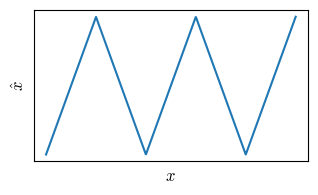

In [4]:

def transform(x, t):
    p = 2/t
    return (2/p)*torch.abs((x-t%2) % (p*2) - p) -1

def sdf_struct(queries):
    queries = torch.tensor(queries, dtype=torch.float32).to(device)
    tx, ty, tz = tiling


    samples = torch.zeros(queries.shape[0], 3)
    samples[:, 0] = transform(queries[:, 0], tx)
    samples[:, 1] = transform(queries[:, 1], ty)
    samples[:, 2] = transform(queries[:, 2], tz)
    lat_vec_red = torch.tensor(latent_vec_interpolation.evaluate(queries.cpu().numpy()), dtype=torch.float32)
    queries = torch.hstack([torch.tensor(lat_vec_red).to(torch.float32).to(device), samples])

    return deep_sdf.utils.decode_sdf(decoder, None, queries).squeeze(1).detach().cpu().numpy()


fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5/2.54))


x = torch.linspace(0, 1, 1000)
y = transform((x-0.5)*2, 5)
ax.plot(x.cpu().numpy(), y.cpu().numpy())
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\^x$")
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(f"screenshots/structure_parameter_transform{graded_string}.png", dpi=600, bbox_inches="tight")

/tmp/ipykernel_660073/1291786042.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  queries = torch.hstack([torch.tensor(lat_vec_red).to(torch.float32).to(device), samples])
/home/michael.kofler/DeepSDF/sdf_sampler/plotting.py:36: UserWarning: The following kwargs were not used by contour: 'color'
  ax[0].contour(X*scale[0], Y*scale[1], sdf, levels=[0], color="black", linewidths=0.5)


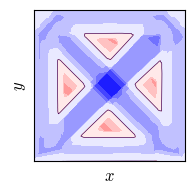

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 5/2.54))
scatter_contour_at_z_level(sdf_struct, custom_axis=ax, res=1000, flip_axes=True, eval_area=(-1,1), scale=(1,1))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f"screenshots/structure_sdf{graded_string}.png", dpi=600, bbox_inches="tight")

/tmp/ipykernel_660073/1291786042.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  queries = torch.hstack([torch.tensor(lat_vec_red).to(torch.float32).to(device), samples])


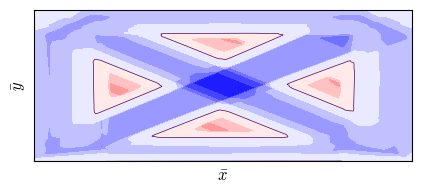

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54*10/4, 5/2.54))
scatter_contour_at_z_level(sdf_struct, custom_axis=ax, res=1000, flip_axes=True, eval_area=(-1,1), scale=(5,2))
ax.set_xlabel(r"$\bar{x}$")
ax.set_ylabel(r"$\bar{y}$")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f"screenshots/structure_sdf_scaled{graded_string}.png", dpi=600, bbox_inches="tight")

In [7]:

# mesh reconstruction

cap_border_dict = {
    "x0": {"cap": 1, "measure": 0.1},
    "x1": {"cap": 1, "measure": 0.1},
    "y0": {"cap": 1, "measure": 0.1},
    "y1": {"cap": 1, "measure": 0.1},
}

N = [N_base * t+1 for t in tiling]

verts, faces = deep_sdf.mesh.create_mesh_microstructure(tiling, decoder, latent_vec_interpolation, "none", cap_border_dict=cap_border_dict, N=N, use_flexicubes=False, device=device)

# geometric parameters
width = 5
height = 5
depth = 1

control_points=np.array([
        [0, 0, 0],
        [0, height, 0],
        [width, 0, 0],
        [width, height, 0]
    ])

deformation_surf = sp.BSpline(
    degrees=[1,1],
    control_points=control_points,
    knot_vectors=[[0, 0, 1, 1],[0, 0, 1, 1]],
)

deformation_volume = deformation_surf.create.extruded(extrusion_vector=[0,0,depth])

# bring slightly outside vertices back
verts[verts>1] = 1
verts[verts<0] = 0

verts_FFD_transformed = deformation_volume.evaluate(verts)

surf_mesh = gus.faces.Faces(verts_FFD_transformed, faces)

r = igl.decimate(surf_mesh.vertices, surf_mesh.faces, int(1e5))
dmesh = gus.Faces(r[1], r[2])


gus.show(dmesh, interactive=False, c="#EDEDED", lw=1)

/usr2/mkofler/DeepSDF_microstructures/deep_sdf/mesh.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  queries = torch.hstack([torch.tensor(lat_vec_red).to(torch.float32), samples[:, 0:3]])


sampling takes: 2.023958


K3DPlotterN(children=(Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680…

AttributeError: 'NoneType' object has no attribute 'screenshot'